In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [81]:
# data = pd.read_csv("env_random/env_random.csv")
data = pd.read_csv("general_env/general_env.csv")
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [82]:
track_durations = (data['timestamp'].diff().dt.total_seconds() / 60).values[1:]
neg_dur = np.argwhere(track_durations < 0)
pairs = np.hstack((neg_dur-2, neg_dur+3))

for fr, to in pairs:
    print(data.iloc[fr: to])

In [83]:
data.head(20)

,timestamp,user_idx,item_idx,relevance_cont,relevance_int,terminated,true_top
0,2019-04-27 10:16:08,94,54,0.527408,2,False,[73 2 17 20 14 27 71 68 65 24]
1,2019-04-27 10:20:02,94,87,0.585186,4,False,[73 28 2 30 20 37 84 62 40 69]
2,2019-04-27 10:23:05,94,72,0.574835,4,False,[20 28 2 73 30 17 3 37 18 47]
3,2019-04-27 10:25:40,94,18,0.482199,2,False,[84 93 17 28 2 56 51 60 47 31]
4,2019-04-27 10:29:16,94,54,0.527408,4,False,[73 56 30 20 17 28 2 46 45 43]
5,2019-04-27 10:31:27,94,92,0.500519,2,False,[84 2 56 73 30 17 20 40 34 37]
6,2019-04-27 10:35:12,94,39,0.440667,2,False,[73 17 37 84 20 60 72 25 65 27]
7,2019-04-27 10:39:16,94,94,0.505230,4,False,[37 20 73 28 84 23 65 64 25 62]
8,2019-04-27 10:43:32,94,28,0.734502,4,False,[56 90 40 27 73 20 17 2 37 51]
9,2019-04-27 10:46:14,94,87,0.585186,4,False,[37 84 17 73 32 26 71 35 68 20]


In [84]:
def get_episodes(data):
    ends = data[data['terminated'] == True].index.values
    starts = np.zeros_like(ends)
    starts[1:] = ends[:-1] + 1
    episodes = pd.DataFrame(starts, columns=['start'])
    episodes['end'] = ends
    episodes['start_time'] = data.iloc[starts]['timestamp'].values
    episodes['end_time'] = data.iloc[ends]['timestamp'].values
    episodes['duration_min'] = (episodes['end_time'] - episodes['start_time']).dt.total_seconds() / 60
    return episodes

get_episodes(data)

,start,end,start_time,end_time,duration_min
0,0,26,2019-04-27 10:16:08,2019-04-27 11:36:31,80.383333
1,27,50,2019-04-27 18:51:03,2019-04-27 20:02:41,71.633333
2,51,90,2019-04-28 03:07:18,2019-04-28 05:09:48,122.500000
3,91,125,2019-04-28 08:09:03,2019-04-28 09:57:12,108.150000
4,126,164,2019-04-28 13:42:30,2019-04-28 15:41:21,118.850000
...,...,...,...,...,...
196,7655,7689,2019-06-27 00:12:56,2019-06-27 01:58:53,105.950000
197,7690,7726,2019-06-27 11:40:27,2019-06-27 13:31:07,110.666667
198,7727,7782,2019-06-27 18:18:01,2019-06-27 21:11:05,173.066667
199,7783,7841,2019-06-28 03:51:09,2019-06-28 06:46:01,174.866667


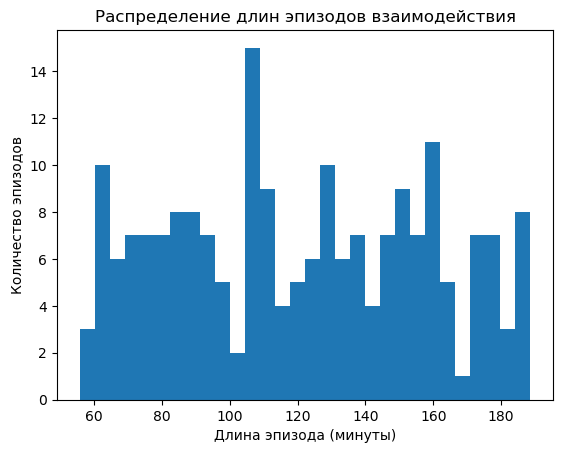

In [85]:

def calculate_interaction_lengths(data):
    # Группировка данных по пользователям и определение длины каждого эпизода взаимодействия
    data['timestamp'] = pd.to_datetime(data['timestamp']) 
    data.sort_values(['user_idx', 'timestamp'], inplace=True)  
    data['terminated_shift'] = data.groupby('user_idx')['terminated'].shift(-1)
    data['interaction_length'] = data.loc[data['terminated_shift'] == 1, 'timestamp'].diff()
    return data

def plot_interaction_lengths(data, ax=None):
    # Построение графика распределения длин эпизодов взаимодействия
    episodes = get_episodes(data)
    # data['interaction_length'] = data['interaction_length'].dt.total_seconds()
    # plt.hist(data['interaction_length'].dropna(), bins=30)
    if ax is None:
        ax = plt.subplot(1,1,1)
    ax.hist(episodes['duration_min'], bins=30)
    ax.set_title('Распределение длин эпизодов взаимодействия')
    ax.set_xlabel('Длина эпизода (минуты)')
    ax.set_ylabel('Количество эпизодов')


# inrs = calculate_interaction_lengths(data)
plot_interaction_lengths(data)

In [86]:
def calculate_interactions_per_episode(data):
    # Добавление столбца для обозначения начала нового эпизода
    data['new_episode'] = data['terminated_shift'].shift(1).fillna(0)
     # Преобразование типа данных столбца 'new_episode' в int
    data['new_episode'] = data['new_episode'].astype(int)

    # Создание столбца с номерами эпизодов для каждого пользователя
    data['episode_idx'] = data.groupby('user_idx')['new_episode'].cumsum()

    # Подсчет количества взаимодействий за каждый эпизод
    interactions_per_episode = data.groupby(['user_idx', 'episode_idx']).size().reset_index(name='interactions')

    return interactions_per_episode


def plot_interactions_per_episode(data, ax=None):
    # Построение гистограммы распределения количества взаимодействий за эпизод
    episodes = get_episodes(data)
    if ax is None:
        ax = plt.subplot(1,1,1)
    ax.hist(episodes['end'] - episodes['start'] + 1, bins=30)
    ax.set_title('Распределение количества взаимодействий за эпизод')
    ax.set_xlabel('Количество взаимодействий за эпизод')
    ax.set_ylabel('Количество эпизодов')

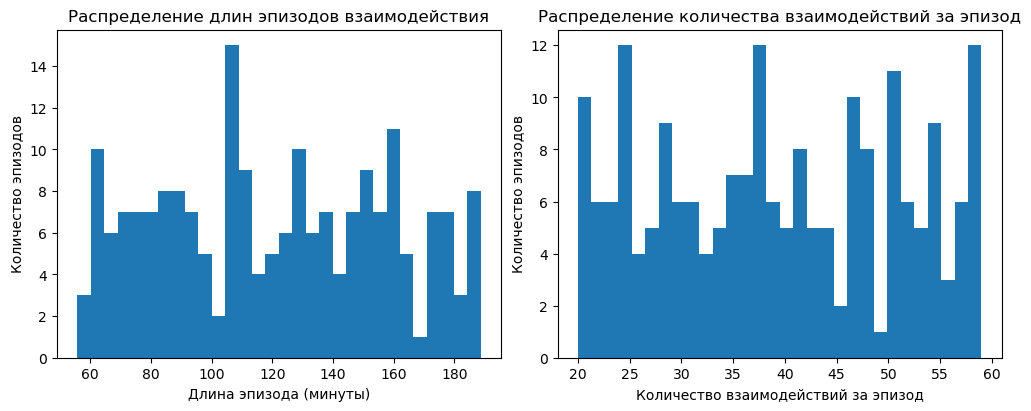

In [87]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4), layout="constrained")

plot_interaction_lengths(data, axs[0])
plot_interactions_per_episode(data, axs[1])

In [88]:

# intrs = calculate_interaction_lengths(data)
# interactions_per_episode = calculate_interactions_per_episode(intrs)
# plot_interaction_lengths(intrs)
# plot_interactions_per_episode(interactions_per_episode)  # Добавлен вызов новой функции

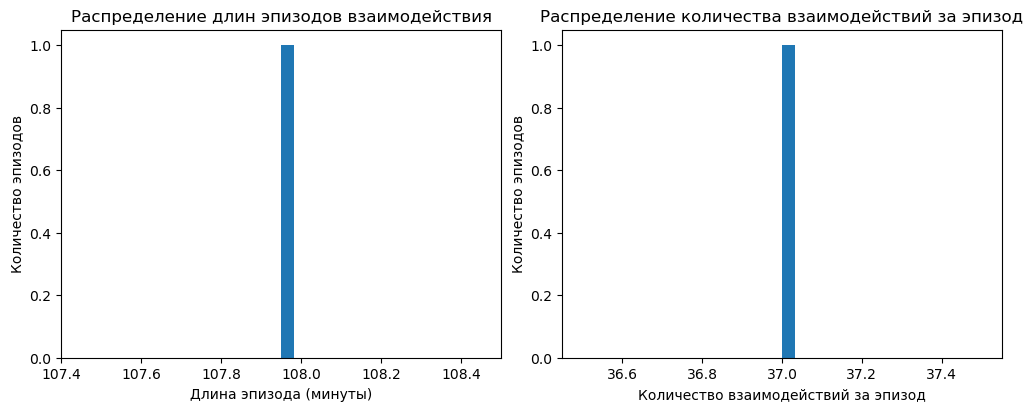

In [89]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4), layout="constrained")

user_0 = data[data['user_idx'] == 6].copy()
user_0.reset_index(inplace=True)

plot_interaction_lengths(user_0, axs[0])
plot_interactions_per_episode(user_0, axs[1])

In [90]:
# user = data[data['user_idx'] == 0]

# intrs = calculate_interaction_lengths(user)
# interactions_per_episode = calculate_interactions_per_episode(intrs)
# #plot_interaction_lengths(intrs)
# plot_interactions_per_episode(interactions_per_episode)  # Добавлен вызов новой функции

In [91]:
def plot_relevance_distribution(data, user_id=None, ax=None):
    if user_id is not None:
        # Фильтрация данных для заданного пользователя
        data = data[data['user_idx'] == user_id]
    
    if ax is None:
        ax = plt.subplot(1,1,1)
        
    # Построение гистограммы распределения relevance_int
    ax.hist(data['relevance_int'].dropna(), bins=30)
    ax.set_title('Распределение relevance_int для пользователя {}'.format(user_id))
    ax.set_xlabel('relevance_int')
    ax.set_ylabel('Количество')


def plot_item_distribution(data, user_id=None, rel=None, ax=None):
    if user_id is not None:
        # Фильтрация данных для заданного пользователя
        data = data[data['user_idx'] == user_id]
    if rel is not None:
        data = data[data['relevance_int'] > rel]

    if ax is None:
        ax = plt.subplot(1,1,1)
        
    # Построение гистограммы распределения item_idx
    ax.hist(data['item_idx'].dropna(), bins=30)
    ax.set_title('Распределение item_idx для пользователя {}'.format(user_id))
    ax.set_xlabel('item_idx')
    ax.set_ylabel('Количество')

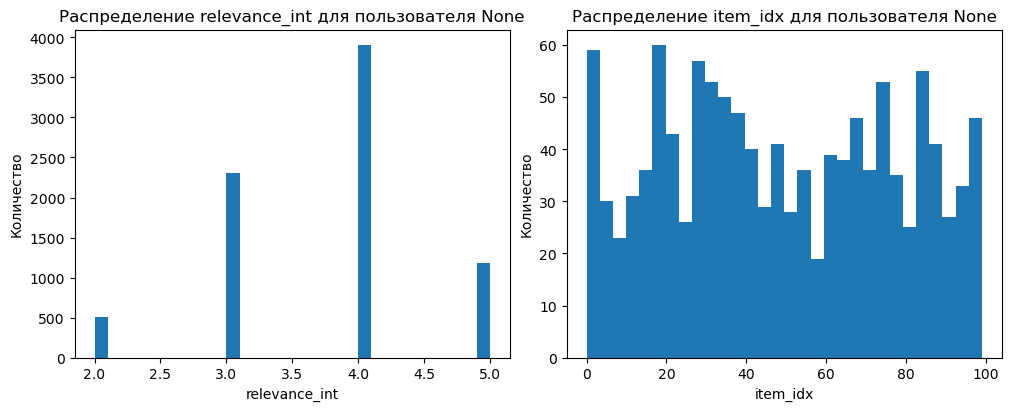

In [92]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4), layout="constrained")

user_id = None
plot_relevance_distribution(data, user_id=user_id, ax=axs[0])  # Добавлен вызов новой функции
plot_item_distribution(data, user_id=user_id, rel=4, ax=axs[1])  # Добавлен вызов новой функции

In [167]:

user = data[data['user_idx'] == 0]

In [162]:
user

,timestamp,user_idx,item_idx,relevance_cont,relevance_int,terminated,true_top,terminated_shift,interaction_length,new_episode,episode_idx
5961,2022-09-04 01:50:48,0,61,0.555307,5,False,[11 23 66 65 35 64 32 75 31 52],False,NaN,0,0
5962,2022-09-04 07:02:48,0,82,0.615722,3,False,[99 74 58 50 43 42 32 30 29 26],False,NaN,0,0
5963,2022-09-04 13:23:48,0,27,0.591523,3,False,[99 55 11 73 12 17 61 22 58 57],False,NaN,0,0
5964,2022-09-04 22:47:48,0,74,0.579658,3,False,[99 43 67 66 63 57 56 50 48 44],False,NaN,0,0
5965,2022-09-05 06:27:48,0,9,0.906516,4,False,[49 98 78 29 30 33 42 46 50 81],False,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6808,2023-02-28 20:03:48,0,4,0.921866,5,False,[49 78 27 28 29 31 71 69 34 67],False,NaN,0,2
6809,2023-03-01 00:14:48,0,87,0.529886,4,False,[49 79 77 22 51 24 73 25 26 30],False,NaN,0,2
6810,2023-03-01 07:00:48,0,81,0.940981,4,False,[49 44 69 67 65 64 63 60 58 48],False,NaN,0,2
6811,2023-03-01 10:34:48,0,81,0.940980,5,False,[99 42 56 29 76 30 74 32 43 81],True,3699780.0,0,2
